Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers.experimental import preprocessing

Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Evaluating the first round of training of the ResNet 50 Model 
- The model intially struggles with class imbalance since there are low accuracy rates with a bias towards classes with more data such as Normal, Other and Diabetes. 
- Training accuracy improved over time but validation accuracy lagged suggesting overfitting. Loss decreased steadily, yet training and validation loss diverged.
- Model frequently misclassified minority classes (e.g., Diabetes as Normal). Therefore there is a need to implement class balance correction techniques for better model generalisation and performance. 

Below images related to these mentioned issues are displayed:


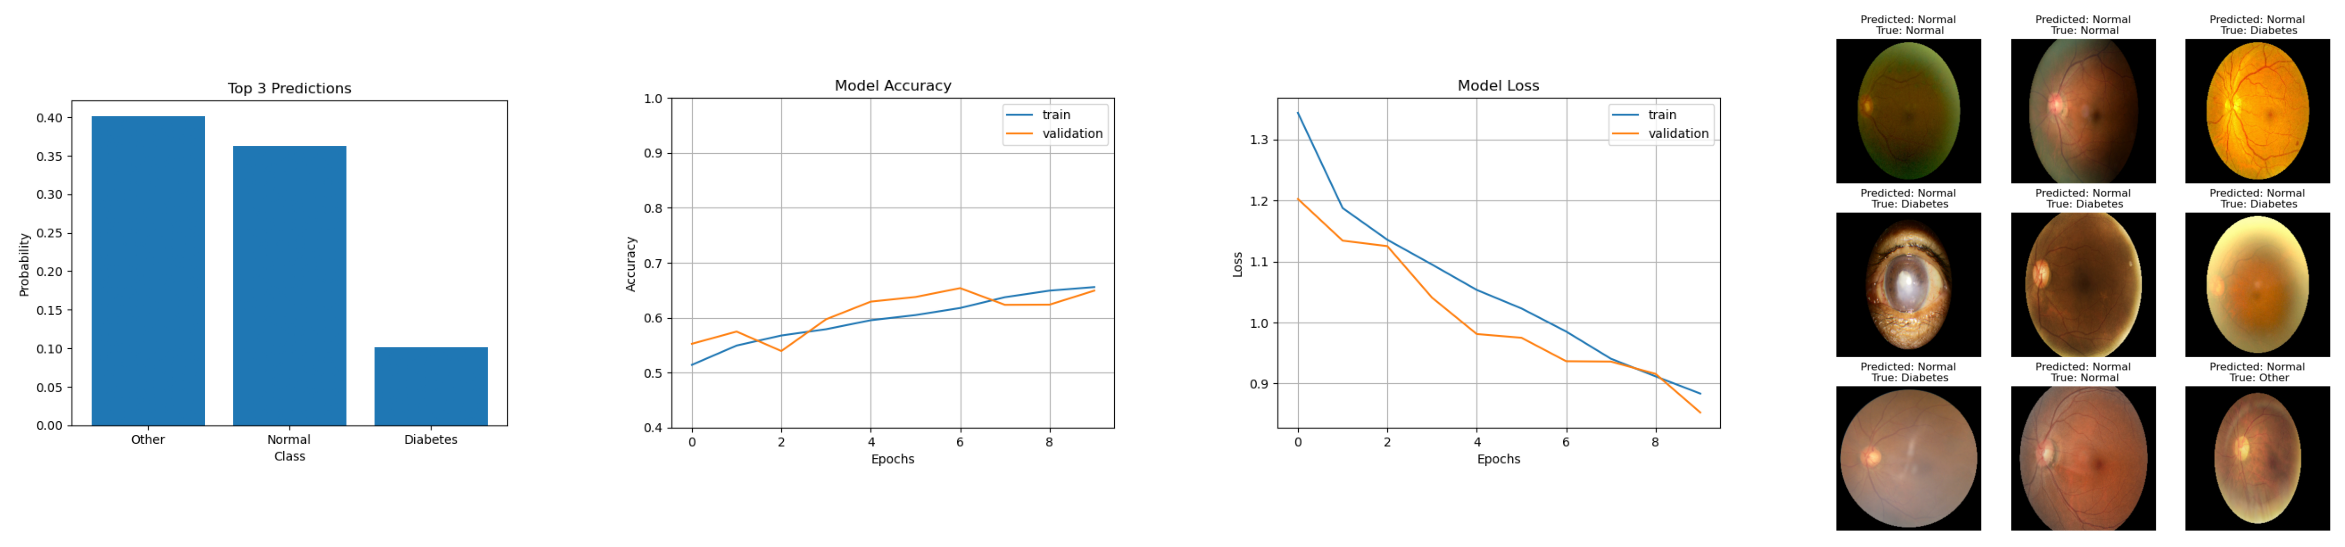

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(30,10))

pred_graph = plt.imread('resnet_50_model/intial-eval/baseTop3predictions.png')
axs[0].imshow(pred_graph)
axs[0].axis('off')

model_acc = plt.imread('resnet_50_model/intial-eval/baseAccuracy.png')
axs[1].imshow(model_acc)
axs[1].axis('off')

model_loss = plt.imread('resnet_50_model/intial-eval/baseLoss.png')
axs[2].imshow(model_loss)
axs[2].axis('off')

test_pred = plt.imread('resnet_50_model/intial-eval/baseTestPred.png')
axs[3].imshow(test_pred)
axs[3].axis('off')

plt.show()



Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H, M, and O are minority classes since they have low image samples, causing class imbalance. 

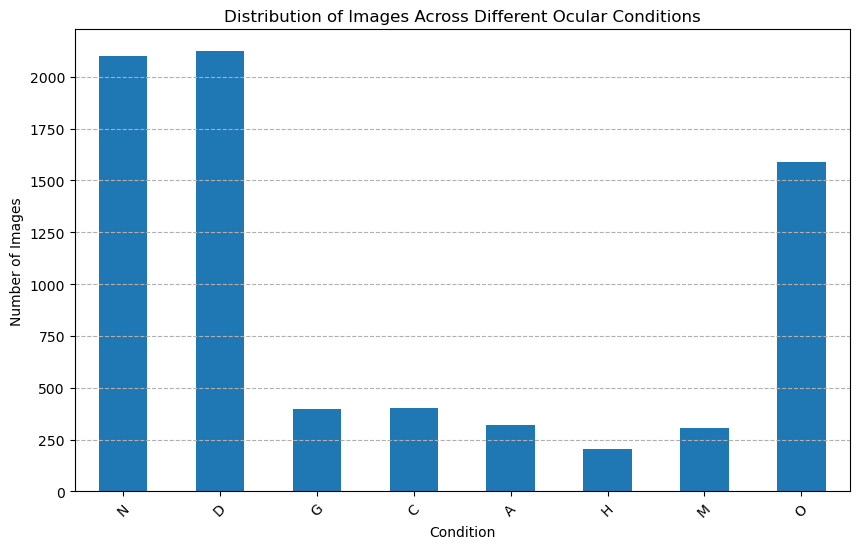

In [4]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [5]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


Dealing with class imbalance - Calculating class weights 
- This approach to addressing class imbalance involves calculating class weights to make the CNN model more sensitive to underrepresented classes, thereby enhancing its performance on imbalanced datasets. A higher class weight signifies that a single sample from a class with a higher weight will carry the same importance as seven samples from a class with lower class weights.

In [6]:
# The dataset is imbalanced, so we will use class weights to balance it out during training                     
total_samples = class_counts.sum()
class_weights = {
    0: total_samples / class_counts[0],
    1: total_samples / class_counts[1],
    2: total_samples / class_counts[2],
    3: total_samples / class_counts[3],
    4: total_samples / class_counts[4],
    5: total_samples / class_counts[5],
    6: total_samples / class_counts[6],
    7: total_samples / class_counts[7]
} 

print(class_weights)

{0: 3.5406949071870537, 1: 3.5040037682524727, 2: 18.738035264483628, 3: 18.50497512437811, 4: 23.31974921630094, 5: 36.645320197044335, 6: 24.31045751633987, 7: 4.684508816120907}


Loading and Visualising the Minority Class Dataset 
- This dataset will include images from the training data that are classified as any of the minority classes -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities)

Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images.

In [10]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Import tqdm for the progress bar
import ast

In [19]:
images_path = 'dataset/ODIR-5K/Training Images/'  
minority_classes = ['G', 'C', 'A', 'H', 'M', 'O']

# Map of minority class labels to their corresponding indices
minority_class_indices = {cls: i for i, cls in enumerate(minority_classes)}

# Filter the dataframe for rows where the target column indicates a minority class
# Here we use a lambda function to check if any of the minority class indices has a 1 in the target list
df_data_minority = df_data[df_data['target'].apply(lambda x: any(x[index] for index in minority_class_indices.values()))]

minority_images = []
minority_labels = []

augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=50,  
    fill_mode='nearest' 
)

minority_class_counts= df_data[['G', 'C', 'A', 'H', 'M', 'O']].sum()
# Count images per class and initialize the dictionary
class_image_counts = {cls: 0 for cls in minority_classes}

def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        label = tf.convert_to_tensor(label, dtype=tf.float32)
        return img, label
    return None, None

def handle_minority_image_result(result):
    img, label = result
    if img is not None:
        # Convert the one-hot encoded label tensor to a numpy array and get the index of the max value (class index)
        label_index = np.argmax(label.numpy())
        # Get the class label corresponding to the class index
        class_label = minority_classes[label_index]
        
        # Check if we need more images for this class using the class label
        if class_image_counts[class_label] < 2000:
            # Append the original image and label
            minority_images.append(img)
            minority_labels.append(label)
            # Increment the count for this class label
            class_image_counts[class_label] += 1
            
            # Augment images until we reach 2000 for this class
            while class_image_counts[class_label] < 2000:
                augmented_img = augmentation.random_transform(img)
                minority_images.append(augmented_img)
                minority_labels.append(label)
                class_image_counts[class_label] += 1
        else:
            # If we already have enough images, we can choose to do nothing
            pass

# Use ThreadPoolExecutor to load and process images that match minority_classes
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data_minority.iterrows(), total=df_data.shape[0], desc='Processing images'):
        # For each minority class, check if the condition is present for either eye
        for minority_class in minority_classes:
            if minority_class in row and row[minority_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[minority_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, left_image_path, row['target']))
                if 'Right-Fundus' in row and row[minority_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, right_image_path, row['target']))
    
    
    for future in tqdm(futures, desc='Collecting results'):
        handle_minority_image_result(future.result())

# Convert to NumPy arrays
minority_images = np.array(minority_images)
minority_labels = np.array(minority_labels)

# Print out the class counts to verify
print("Image counts per class after augmentation:")
for cls in minority_classes:
    print(f"Class {cls}: {class_image_counts[cls]}")

Processing images:  85%|████████▌ | 5452/6392 [00:00<00:00, 9120.26it/s]


Image counts per class after augmentation:
Class G: 2000
Class C: 2000
Class A: 2000
Class H: 2000
Class M: 2000
Class O: 2000


Working data augmentation 

In [18]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # Import tqdm for the progress bar

images_path = 'dataset/ODIR-5K/Training Images/'  
minority_classes = ['G', 'C', 'A', 'H', 'M', 'O']

minority_images = []
minority_labels = []

augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=50,  
    fill_mode='nearest' 
)

minority_class_counts= df_data[['G', 'C', 'A', 'H', 'M', 'O']].sum()
# Count images per class and initialize the dictionary
class_image_counts = minority_class_counts.to_dict()


def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None

def handle_minority_image_result(result):
    img, label = result
    if img is not None:
        # Check if we need more images for this class
        if class_image_counts[label] < 2000:
            # Append the original image
            minority_images.append(img)
            minority_labels.append(label)
            class_image_counts[label] += 1
            
            # Augment images until we reach 2000 for this class
            while class_image_counts[label] < 2000:
                augmented_img = augmentation.random_transform(img)
                minority_images.append(augmented_img)
                minority_labels.append(label)
                class_image_counts[label] += 1
        else:
            # If we already have enough images, we can choose to do nothing
            # or we could replace some of the original images with augmented ones
            pass

# Use ThreadPoolExecutor to load and process images that match minority_classes
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data.iterrows(), total=df_data.shape[0], desc='Processing images'):
        # For each minority class, check if the condition is present for either eye
        for minority_class in minority_classes:
            if minority_class in row and row[minority_class] == 1:  # Check if the condition is marked for this row
                # Check each eye and process the image if the condition is present
                if 'Left-Fundus' in row and row[minority_class] == 1:
                    left_image_path = os.path.join(images_path, row['Left-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, left_image_path, minority_class))
                if 'Right-Fundus' in row and row[minority_class] == 1:
                    right_image_path = os.path.join(images_path, row['Right-Fundus'])
                    # Pass the minority class as the label
                    futures.append(executor.submit(load_process_minority_image, right_image_path, minority_class))
    
    
    for future in tqdm(futures, desc='Collecting results'):
        handle_minority_image_result(future.result())

# Convert to NumPy arrays
minority_images = np.array(minority_images)
minority_labels = np.array(minority_labels)

# Print out the class counts to verify
print("Image counts per class after augmentation:")
for cls in minority_classes:
    print(f"Class {cls}: {class_image_counts[cls]}")

Processing images: 100%|██████████| 6392/6392 [00:01<00:00, 3799.54it/s]


Image counts per class after augmentation:
Class G: 2000
Class C: 2000
Class A: 2000
Class H: 2000
Class M: 2000
Class O: 2000


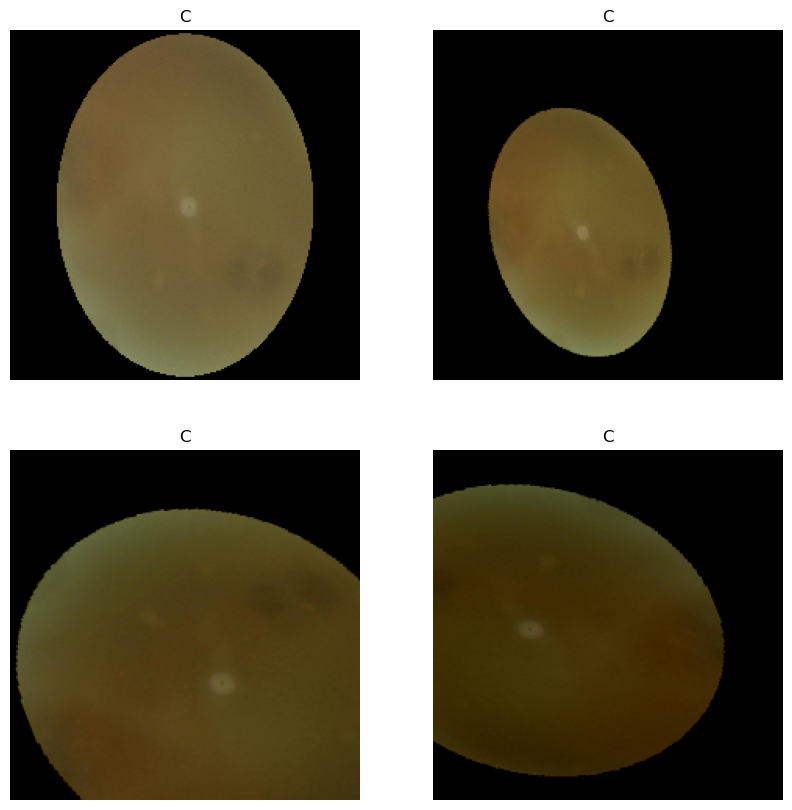

In [ ]:
plt.figure(figsize=(10,10))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(minority_images[i].astype('uint8'))
    plt.title(minority_labels[i])
    plt.axis('off')

plt.show()

Preparing augmentated data for training
- Splitting the augmented minority data into training and validation sets. 

In [ ]:
def process_labels(label_string):
    # Assuming label_string is the raw string label from your dataset
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return label

def normalize_images(image, label):
    # Normalize images to have values between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Assuming minority_images and minority_labels are your prepared data
minority_ds = tf.data.Dataset.from_tensor_slices((minority_images, minority_labels))

# Apply label processing and image normalization
minority_ds = minority_ds.map(lambda img, lbl: (img, process_labels(lbl)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
minority_ds = minority_ds.map(normalize_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch the dataset
minority_ds = minority_ds.shuffle(buffer_size=len(minority_images))

# Calculate the number of samples for training
train_size = int(0.8 * len(minority_images))

# Split the dataset
train_dataset = minority_ds.take(train_size)
val_dataset = minority_ds.skip(train_size)

# Batch the datasets
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

# Prefetch the datasets
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print("size of training dataset: ", len(train_dataset))
print("size of validation dataset: ", len(val_dataset))

size of training dataset:  220
size of validation dataset:  55


Visualising Training and Validation Data 

In [ ]:
print("Training dataset")
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)

    # Convert labels to numbers
    labels = tf.strings.to_number(labels, out_type=tf.float32)

# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

In [ ]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

Training the model

In [ ]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

resnet_50_model.summary()


In [ ]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
history = resnet_50_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Evaluating Model 

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Loading Test Data 

In [ ]:
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)

    return image

In [ ]:
from pathlib import Path


data_dir = Path('dataset/ODIR-5K/')
test_dataset = list(data_dir.glob('Testing Images/*'))


test_dataset = [str(path) for path in test_dataset]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(parse_image)


# Now you can batch, shuffle, and prefetch the dataset as needed
test_dataset = test_dataset.batch(32)  # batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


# Visualize the data
plt.figure(figsize=(10,10))

for i, image in enumerate(test_dataset.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.axis('off')



In [ ]:
print("size of test dataset: ", len(test_dataset))    

Making Predictions


In [ ]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0] / 255)
    plt.title("Predicted: {}\n True: {}".format(output_class, class_labels[np.argmax(labels[i])]))
    plt.axis("off")

In [ ]:

# Get the class with the highest probability
pred_class = np.argmax(pred)
print(pred_class)

# Get the class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
class_labels[pred_class]

# Get the top 3 class labels
top3_class_indices = pred[0].argsort()[-3:][::-1]
top3_class_indices

# Get the top 3 class labels
top3_class_labels = [class_labels[i] for i in top3_class_indices]
top3_class_labels

# Get the top 3 class probabilities
top3_class_probabilities = pred[0][top3_class_indices]
top3_class_probabilities

# Visualize the top 3 class labels and their probabilities
plt.bar(top3_class_labels, top3_class_probabilities)
plt.ylabel('Probability')
plt.xlabel('Class')
plt.title('Top 3 Predictions')
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model')